# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df_t5=pd.read_parquet('train/pspa_t5.parquet').reset_index()
df_esm=pd.read_parquet('train/pspa_esm.parquet').reset_index()
df_onehot = pd.read_parquet('train/pspa_onehot.parquet').reset_index()

In [5]:
(df_onehot['index'] == df_esm['index']).value_counts()

index
True    368
Name: count, dtype: int64

In [6]:
(df_t5['index'] == df_esm['index']).value_counts()

index
True    368
Name: count, dtype: int64

In [7]:
t5_col = df_t5.columns[df_t5.columns.str.startswith('T5_')]

In [8]:
t5_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [9]:
esm_col = df_esm.columns[df_esm.columns.str.startswith('esm_')]

In [10]:
esm_col

Index(['esm_0', 'esm_1', 'esm_2', 'esm_3', 'esm_4', 'esm_5', 'esm_6', 'esm_7',
       'esm_8', 'esm_9',
       ...
       'esm_1270', 'esm_1271', 'esm_1272', 'esm_1273', 'esm_1274', 'esm_1275',
       'esm_1276', 'esm_1277', 'esm_1278', 'esm_1279'],
      dtype='object', length=1280)

In [11]:
target_col = df_t5.columns[~df_t5.columns.isin(t5_col)][1:]

In [12]:
target_col

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

In [13]:
onehot_col = df_onehot.columns[~df_onehot.columns.isin(target_col)][1:]

In [14]:
onehot_col

Index(['65_-', '65_A', '65_C', '65_D', '65_E', '65_F', '65_G', '65_H', '65_I',
       '65_K',
       ...
       '3192_M', '3192_N', '3192_P', '3192_Q', '3192_R', '3192_S', '3192_T',
       '3192_V', '3192_W', '3192_Y'],
      dtype='object', length=6849)

In [15]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df_t5['index'].tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

## Split

In [16]:
splits = get_splits(pspa_info, stratified='subfamily',nfold=5)

split0 = splits[0]

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
# subfamily in train set: 140
# subfamily in test set: 70


/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Dataset

In [17]:
# dataset
ds_t5 = GeneralDataset(df_t5,t5_col,target_col)
ds_esm = GeneralDataset(df_esm,esm_col,target_col)
ds_onehot = GeneralDataset(df_onehot,onehot_col,target_col)

In [18]:
len(ds_t5)

368

In [19]:
dl_t5 = DataLoader(ds_t5, batch_size=64, shuffle=True)
dl_esm = DataLoader(ds_esm, batch_size=64, shuffle=True)
dl_onehot = DataLoader(ds_onehot, batch_size=64, shuffle=True)

In [20]:
xb,yb = next(iter(dl_t5))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [21]:
n_t5 = len(t5_col)
n_esm = len(esm_col)
n_onehot = len(onehot_col)
n_target = len(target_col)

In [22]:
n_t5,n_esm,n_onehot

(1024, 1280, 6849)

In [23]:

# def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

def get_cnn_t5(): return PSSM_model(n_t5,n_target,model='CNN')
def get_cnn_esm(): return PSSM_model(n_esm,n_target,model='CNN')
def get_cnn_onehot(): return PSSM_model(n_onehot,n_target,model='CNN')

In [24]:
model = get_cnn_t5()

In [25]:
logits= model(xb)

In [26]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [27]:
CE(logits,yb)

tensor(3.3157, grad_fn=<MeanBackward0>)

## Metrics

In [28]:
KLD(logits,yb)

tensor(0.5744, grad_fn=<MeanBackward0>)

In [29]:
JSD(logits,yb)

tensor(0.1175, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [30]:
oof_t5 = train_dl_cv(df_t5,t5_col,target_col,
                  splits = splits,
                  model_func = get_cnn_t5,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.208693,3.128794,0.382771,0.082101,00:01
1,3.100871,3.012646,0.266622,0.062313,00:00
2,3.029969,3.079528,0.333504,0.055637,00:00
3,2.990634,3.086870,0.340846,0.050486,00:00
4,2.965003,3.033759,0.287735,0.045743,00:00
5,2.949064,2.937042,0.191018,0.039936,00:00
6,2.929630,2.853435,0.107411,0.025641,00:00
7,2.910378,2.820849,0.074825,0.018170,00:00
8,2.892387,2.807225,0.061201,0.014905,00:00
9,2.876801,2.809036,0.063012,0.015206,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.224772,3.124444,0.373262,0.080508,00:00
1,3.116907,3.005830,0.254648,0.059894,00:00
2,3.037952,3.013795,0.262614,0.046517,00:00
3,2.996115,3.044918,0.293736,0.047594,00:01
4,2.971271,3.044315,0.293133,0.047225,00:00
5,2.948732,2.935985,0.184804,0.039795,00:00
6,2.926746,2.871976,0.120794,0.028774,00:00
7,2.906552,2.827108,0.075927,0.018488,00:00
8,2.888970,2.814232,0.063050,0.015112,00:00
9,2.873151,2.815451,0.064270,0.015515,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.208204,3.124868,0.373740,0.080566,00:00
1,3.099473,3.009431,0.258302,0.062059,00:00
2,3.027796,3.085747,0.334619,0.051113,00:00
3,2.984059,3.102111,0.350982,0.052953,00:00
4,2.955881,2.995615,0.244487,0.043623,00:00
5,2.934876,2.896333,0.145204,0.033681,00:00
6,2.917277,2.849064,0.097936,0.023716,00:00
7,2.899827,2.826292,0.075162,0.018190,00:00
8,2.883373,2.808915,0.057786,0.014109,00:00
9,2.868855,2.808941,0.057812,0.014150,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.219481,3.132898,0.385396,0.082045,00:00
1,3.112693,3.014322,0.266821,0.062557,00:00
2,3.034081,3.021365,0.273864,0.048785,00:00
3,2.992430,3.132051,0.384550,0.054110,00:00
4,2.967404,3.092783,0.345281,0.049233,00:00
5,2.943843,2.987054,0.239552,0.041796,00:00
6,2.923974,2.848786,0.101284,0.023930,00:00
7,2.908860,2.841232,0.093730,0.022514,00:00
8,2.894151,2.817079,0.069577,0.017042,00:00
9,2.879940,2.805872,0.058370,0.014382,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.209879,3.118299,0.375108,0.081633,00:00
1,3.099433,2.999229,0.256038,0.059177,00:00
2,3.024407,3.020353,0.277162,0.047582,00:00
3,2.984462,3.107616,0.364426,0.049521,00:00
4,2.961728,2.929673,0.186483,0.041670,00:02
5,2.941056,2.863092,0.119902,0.027996,00:00
6,2.920160,2.833935,0.090745,0.022001,00:00
7,2.901923,2.822537,0.079346,0.019137,00:00
8,2.890568,2.823365,0.080175,0.019452,00:00
9,2.877597,2.827079,0.083888,0.020281,00:00


In [31]:
oof_esm = train_dl_cv(df_esm,esm_col,target_col,
                  splits = splits,
                  model_func = get_cnn_esm,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.210144,3.126664,0.380640,0.081477,00:00
1,3.094224,3.015490,0.269467,0.059442,00:00
2,3.025384,2.988191,0.242167,0.044739,00:00
3,2.985507,2.930832,0.184808,0.041330,00:00
4,2.964648,2.874135,0.128111,0.030308,00:00
5,2.948381,2.847165,0.101141,0.024361,00:00
6,2.930104,2.832477,0.086453,0.020797,00:00
7,2.914412,2.835015,0.088990,0.021402,00:00
8,2.899032,2.857343,0.111319,0.024216,00:00
9,2.885580,2.854738,0.108714,0.024414,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.209157,3.124184,0.373003,0.080574,00:00
1,3.097771,3.010767,0.259585,0.059719,00:00
2,3.027131,2.949203,0.198021,0.044139,00:00
3,2.988480,2.909757,0.158576,0.036887,00:00
4,2.965666,2.884343,0.133161,0.031872,00:00
5,2.946719,2.838646,0.087464,0.021037,00:00
6,2.925279,2.829162,0.077981,0.018606,00:00
7,2.905434,2.825915,0.074734,0.017959,00:00
8,2.887427,2.818479,0.067297,0.016243,00:00
9,2.872207,2.820393,0.069212,0.016602,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.204782,3.121326,0.370197,0.080019,00:00
1,3.090521,2.994740,0.243612,0.053639,00:02
2,3.021498,2.959470,0.208341,0.042324,00:00
3,2.982385,2.905391,0.154262,0.035859,00:00
4,2.970369,2.883059,0.131930,0.030820,00:00
5,2.950835,2.894393,0.143265,0.033162,00:00
6,2.932156,2.869148,0.118020,0.027091,00:00
7,2.913074,2.838807,0.087678,0.021088,00:00
8,2.895461,2.829754,0.078625,0.018987,00:00
9,2.881042,2.818281,0.067153,0.016370,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.207127,3.119480,0.371978,0.080448,00:00
1,3.092291,3.005714,0.258212,0.059177,00:00
2,3.021772,2.919223,0.171721,0.040524,00:00
3,2.984675,2.909510,0.162008,0.039232,00:00
4,2.964647,2.858355,0.110853,0.026905,00:00
5,2.946732,2.843492,0.095990,0.022964,00:00
6,2.928368,2.838065,0.090563,0.021862,00:00
7,2.909547,2.830971,0.083469,0.020223,00:00
8,2.892228,2.814278,0.066776,0.016287,00:00
9,2.876641,2.808251,0.060749,0.014857,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.208281,3.137901,0.394711,0.083809,00:00
1,3.098066,3.024431,0.281240,0.065753,00:00
2,3.022813,2.971657,0.228467,0.044428,00:00
3,2.986743,2.926676,0.183486,0.040435,00:00
4,2.967233,2.853103,0.109913,0.026132,00:00
5,2.948643,2.892651,0.149460,0.031096,00:00
6,2.930581,2.822967,0.079776,0.019233,00:00
7,2.911179,2.825162,0.081972,0.018694,00:00
8,2.893390,2.819040,0.075849,0.017391,00:00
9,2.877729,2.812762,0.069571,0.016635,00:00


In [32]:
oof_onehot = train_dl_cv(df_onehot,onehot_col,target_col,
                  splits = splits,
                  model_func = get_cnn_onehot,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.223519,3.127483,0.381460,0.081914,00:00
1,3.096982,2.943514,0.197490,0.050214,00:00
2,3.020276,3.038424,0.292400,0.055226,00:00
3,2.973040,3.166019,0.419995,0.075754,00:00
4,2.949337,3.058903,0.312878,0.060635,00:00
5,2.927932,2.941810,0.195786,0.040103,00:00
6,2.907472,2.885069,0.139045,0.030783,00:00
7,2.888231,2.839957,0.093933,0.021463,00:00
8,2.870211,2.814317,0.068293,0.016317,00:00
9,2.855001,2.809921,0.063896,0.015245,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.219286,3.119179,0.367997,0.079395,00:00
1,3.090204,2.927745,0.176563,0.045232,00:00
2,3.011515,2.954673,0.203492,0.043658,00:00
3,2.969590,3.247586,0.496404,0.082400,00:00
4,2.948106,3.003263,0.252082,0.049566,00:00
5,2.927103,2.921316,0.170135,0.033944,00:00
6,2.907334,2.886690,0.135509,0.029024,00:00
7,2.888557,2.854697,0.103515,0.023165,00:00
8,2.871500,2.826414,0.075233,0.017822,00:00
9,2.857023,2.819996,0.068815,0.016454,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.229974,3.131977,0.380848,0.081537,00:00
1,3.101890,2.967034,0.215905,0.055040,00:00
2,3.020017,2.987113,0.235984,0.044733,00:00
3,2.974253,3.083392,0.332264,0.062410,00:00
4,2.945700,2.991428,0.240300,0.050417,00:00
5,2.925005,2.866454,0.115326,0.026391,00:02
6,2.903293,2.829615,0.078486,0.018936,00:00
7,2.883883,2.818384,0.067256,0.016305,00:00
8,2.867076,2.815533,0.064405,0.015496,00:00
9,2.852345,2.805813,0.054684,0.013297,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.222991,3.129804,0.382302,0.081776,00:00
1,3.096829,2.950116,0.202614,0.051682,00:00
2,3.015394,2.985261,0.237759,0.048941,00:00
3,2.974832,3.160371,0.412869,0.076034,00:00
4,2.951609,2.981685,0.234183,0.049281,00:00
5,2.928437,2.851189,0.103687,0.024197,00:00
6,2.906490,2.855957,0.108455,0.025388,00:00
7,2.885834,2.825890,0.078388,0.018701,00:00
8,2.868220,2.816926,0.069424,0.016679,00:00
9,2.853554,2.804998,0.057496,0.013989,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.223938,3.125748,0.382557,0.082488,00:00
1,3.095077,2.936485,0.193294,0.049938,00:00
2,3.013487,3.040129,0.296938,0.056410,00:00
3,2.970957,3.121289,0.378098,0.072242,00:00
4,2.945582,3.008442,0.265252,0.055330,00:00
5,2.927747,2.894122,0.150932,0.032953,00:00
6,2.907105,2.849467,0.106276,0.024425,00:00
7,2.887716,2.823748,0.080558,0.018927,00:00
8,2.871275,2.814253,0.071062,0.016872,00:00
9,2.856822,2.806439,0.063249,0.015348,00:00


## Score

In [33]:
from katlas.clustering import *

from functools import partial

In [34]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [35]:
jsd_df = partial(score_df,func=js_divergence_flat)
kld_df = partial(score_df,func=kl_divergence_flat)

In [36]:
target=df_t5[target_col].copy()

In [37]:
(oof_t5.nfold == oof_esm.nfold).value_counts()

nfold
True    368
Name: count, dtype: int64

In [38]:
pspa_info['split'] = oof_t5.nfold

In [39]:
pspa_info['t5'] =jsd_df(target,oof_t5)
pspa_info['esm'] =jsd_df(target,oof_esm)
pspa_info['onehot'] =jsd_df(target,oof_onehot)

In [40]:
pspa_info

,kinase,subfamily,family,group,split,t5,esm,onehot
0,Q2M2I8_AAK1_HUMAN_KD1,NAK,NAK,Other,3,0.012471,0.008610,0.024491
1,P27037_AVR2A_HUMAN_KD1,STKR2,STKR,TKL,1,0.003780,0.005345,0.020368
2,Q13705_AVR2B_HUMAN_KD1,STKR2,STKR,TKL,4,0.004462,0.004456,0.026160
3,P31749_AKT1_HUMAN_KD1,Akt,Akt,AGC,0,0.004570,0.002787,0.016499
4,P31751_AKT2_HUMAN_KD1,Akt,Akt,AGC,3,0.004816,0.004211,0.004663
...,...,...,...,...,...,...,...,...
363,P17948_VGFR1_HUMAN_KD1,VEGFR,VEGFR,TK,1,0.011994,0.009626,0.017355
364,P35968_VGFR2_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.004726,0.005081,0.014755
365,P35916_VGFR3_HUMAN_KD1,VEGFR,VEGFR,TK,2,0.004883,0.005356,0.013703
366,P07947_YES_HUMAN_KD1,Src,Src,TK,3,0.004104,0.006413,0.007982


In [41]:
from katlas.plot import *

In [42]:
set_sns()

Text(0, 0.5, 'JS divergence')

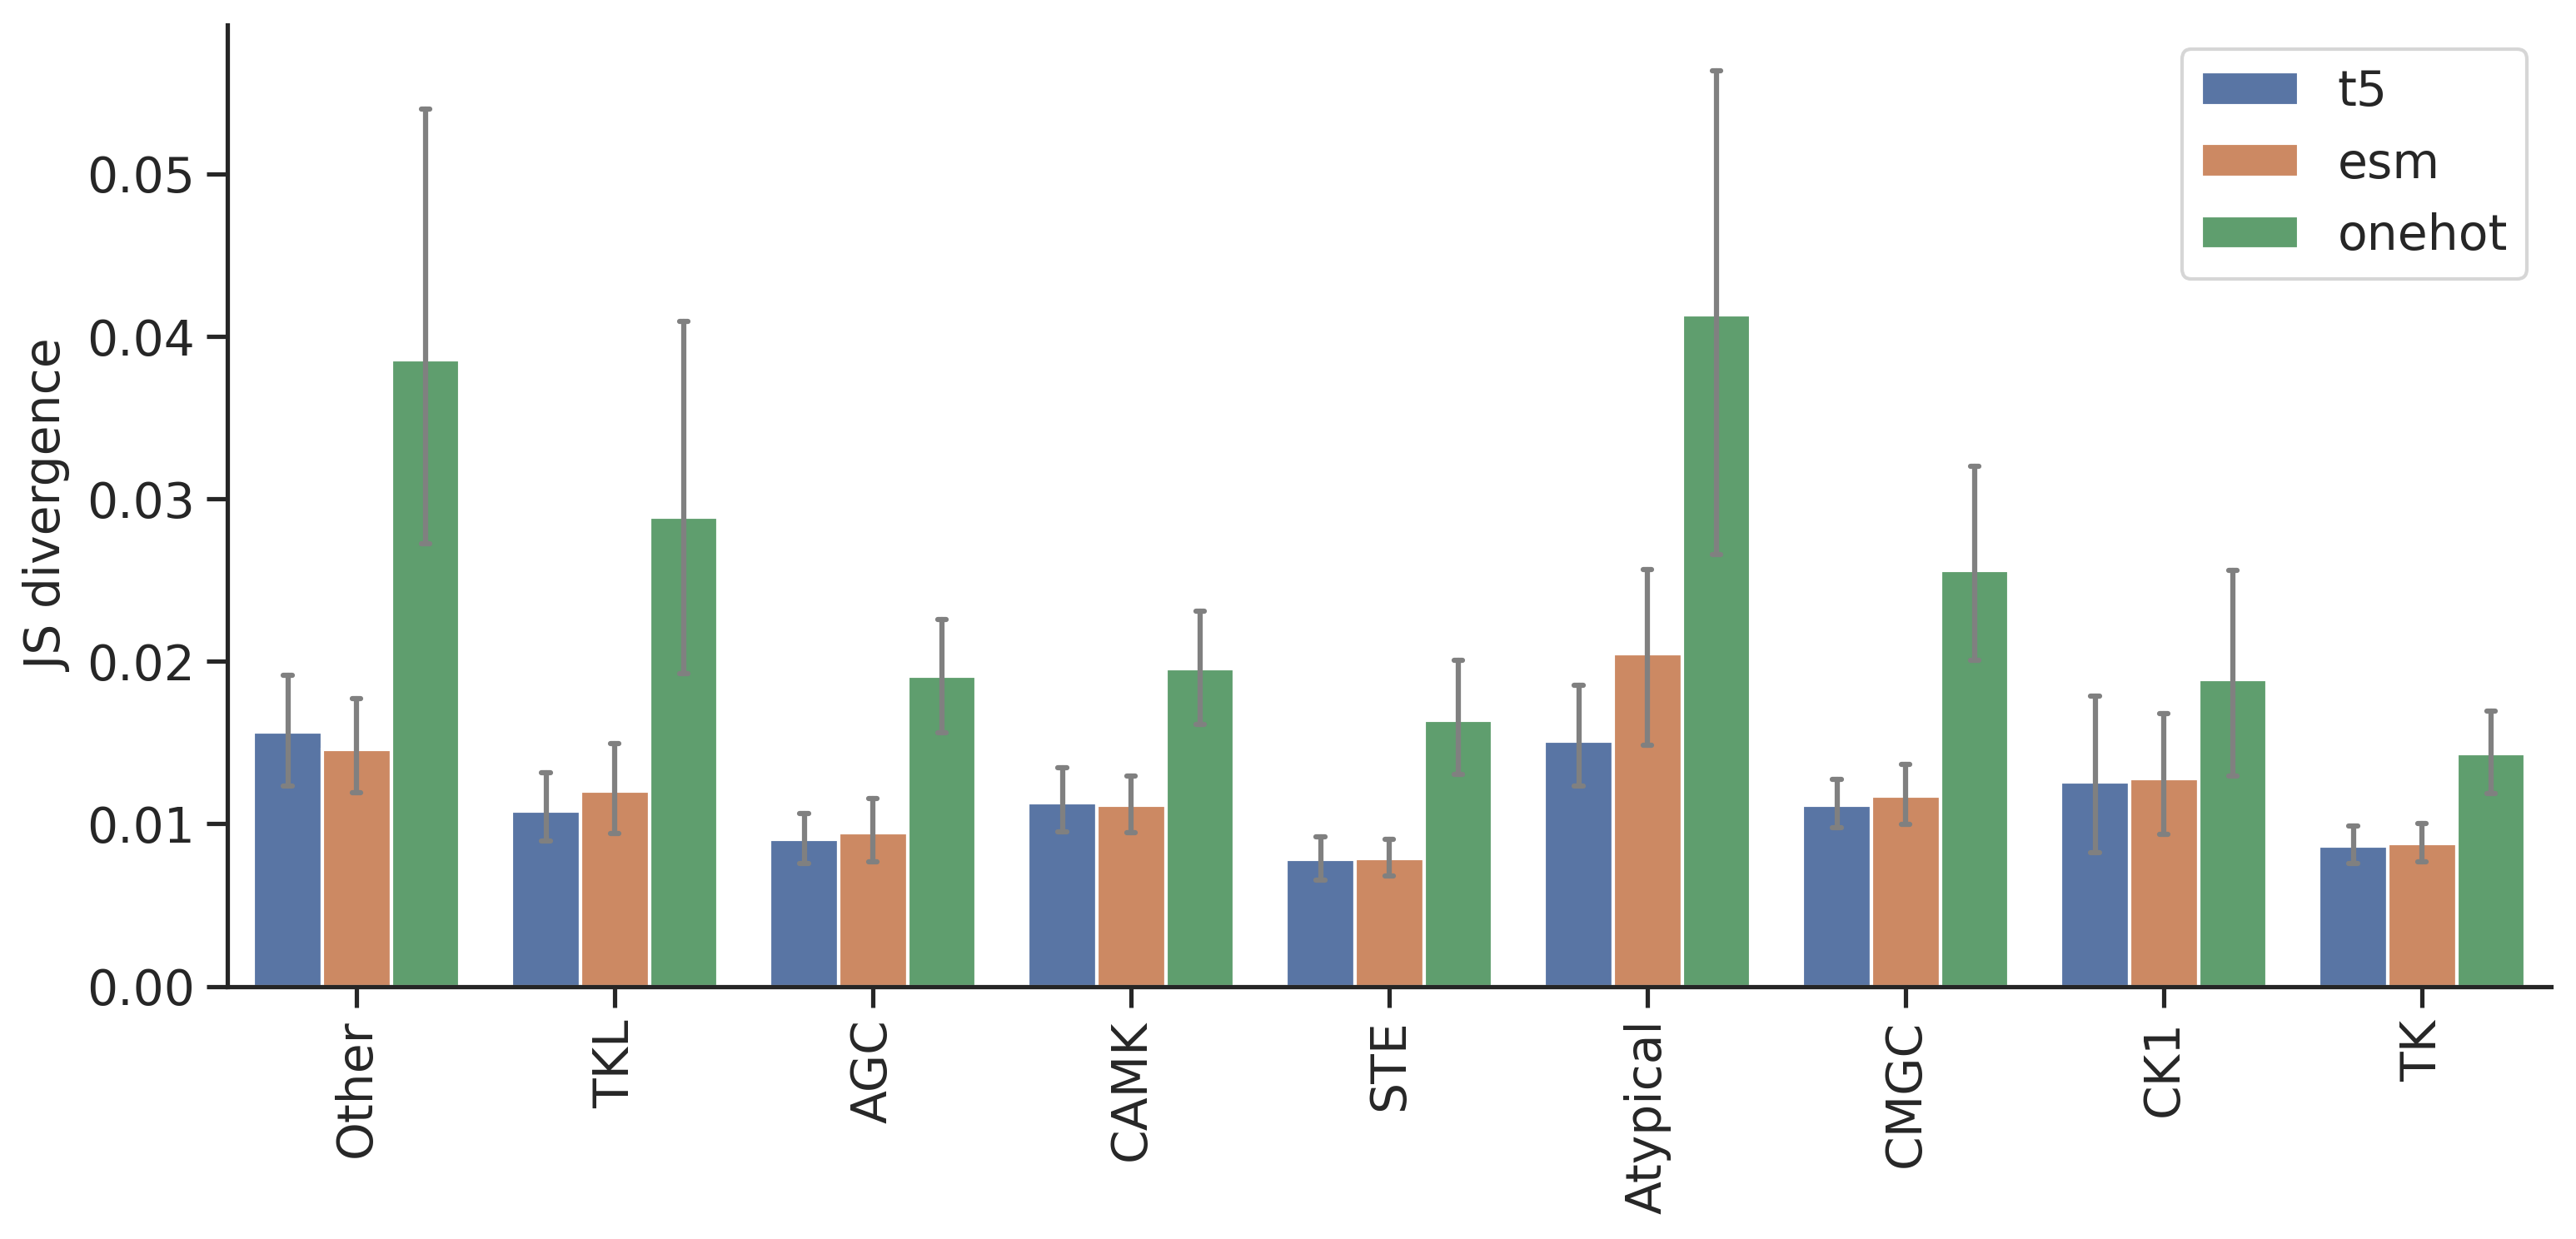

In [43]:
plot_group_bar(pspa_info,['t5','esm','onehot'],group='group')
plt.ylabel('JS divergence')

Text(0, 0.5, 'JS divergence')

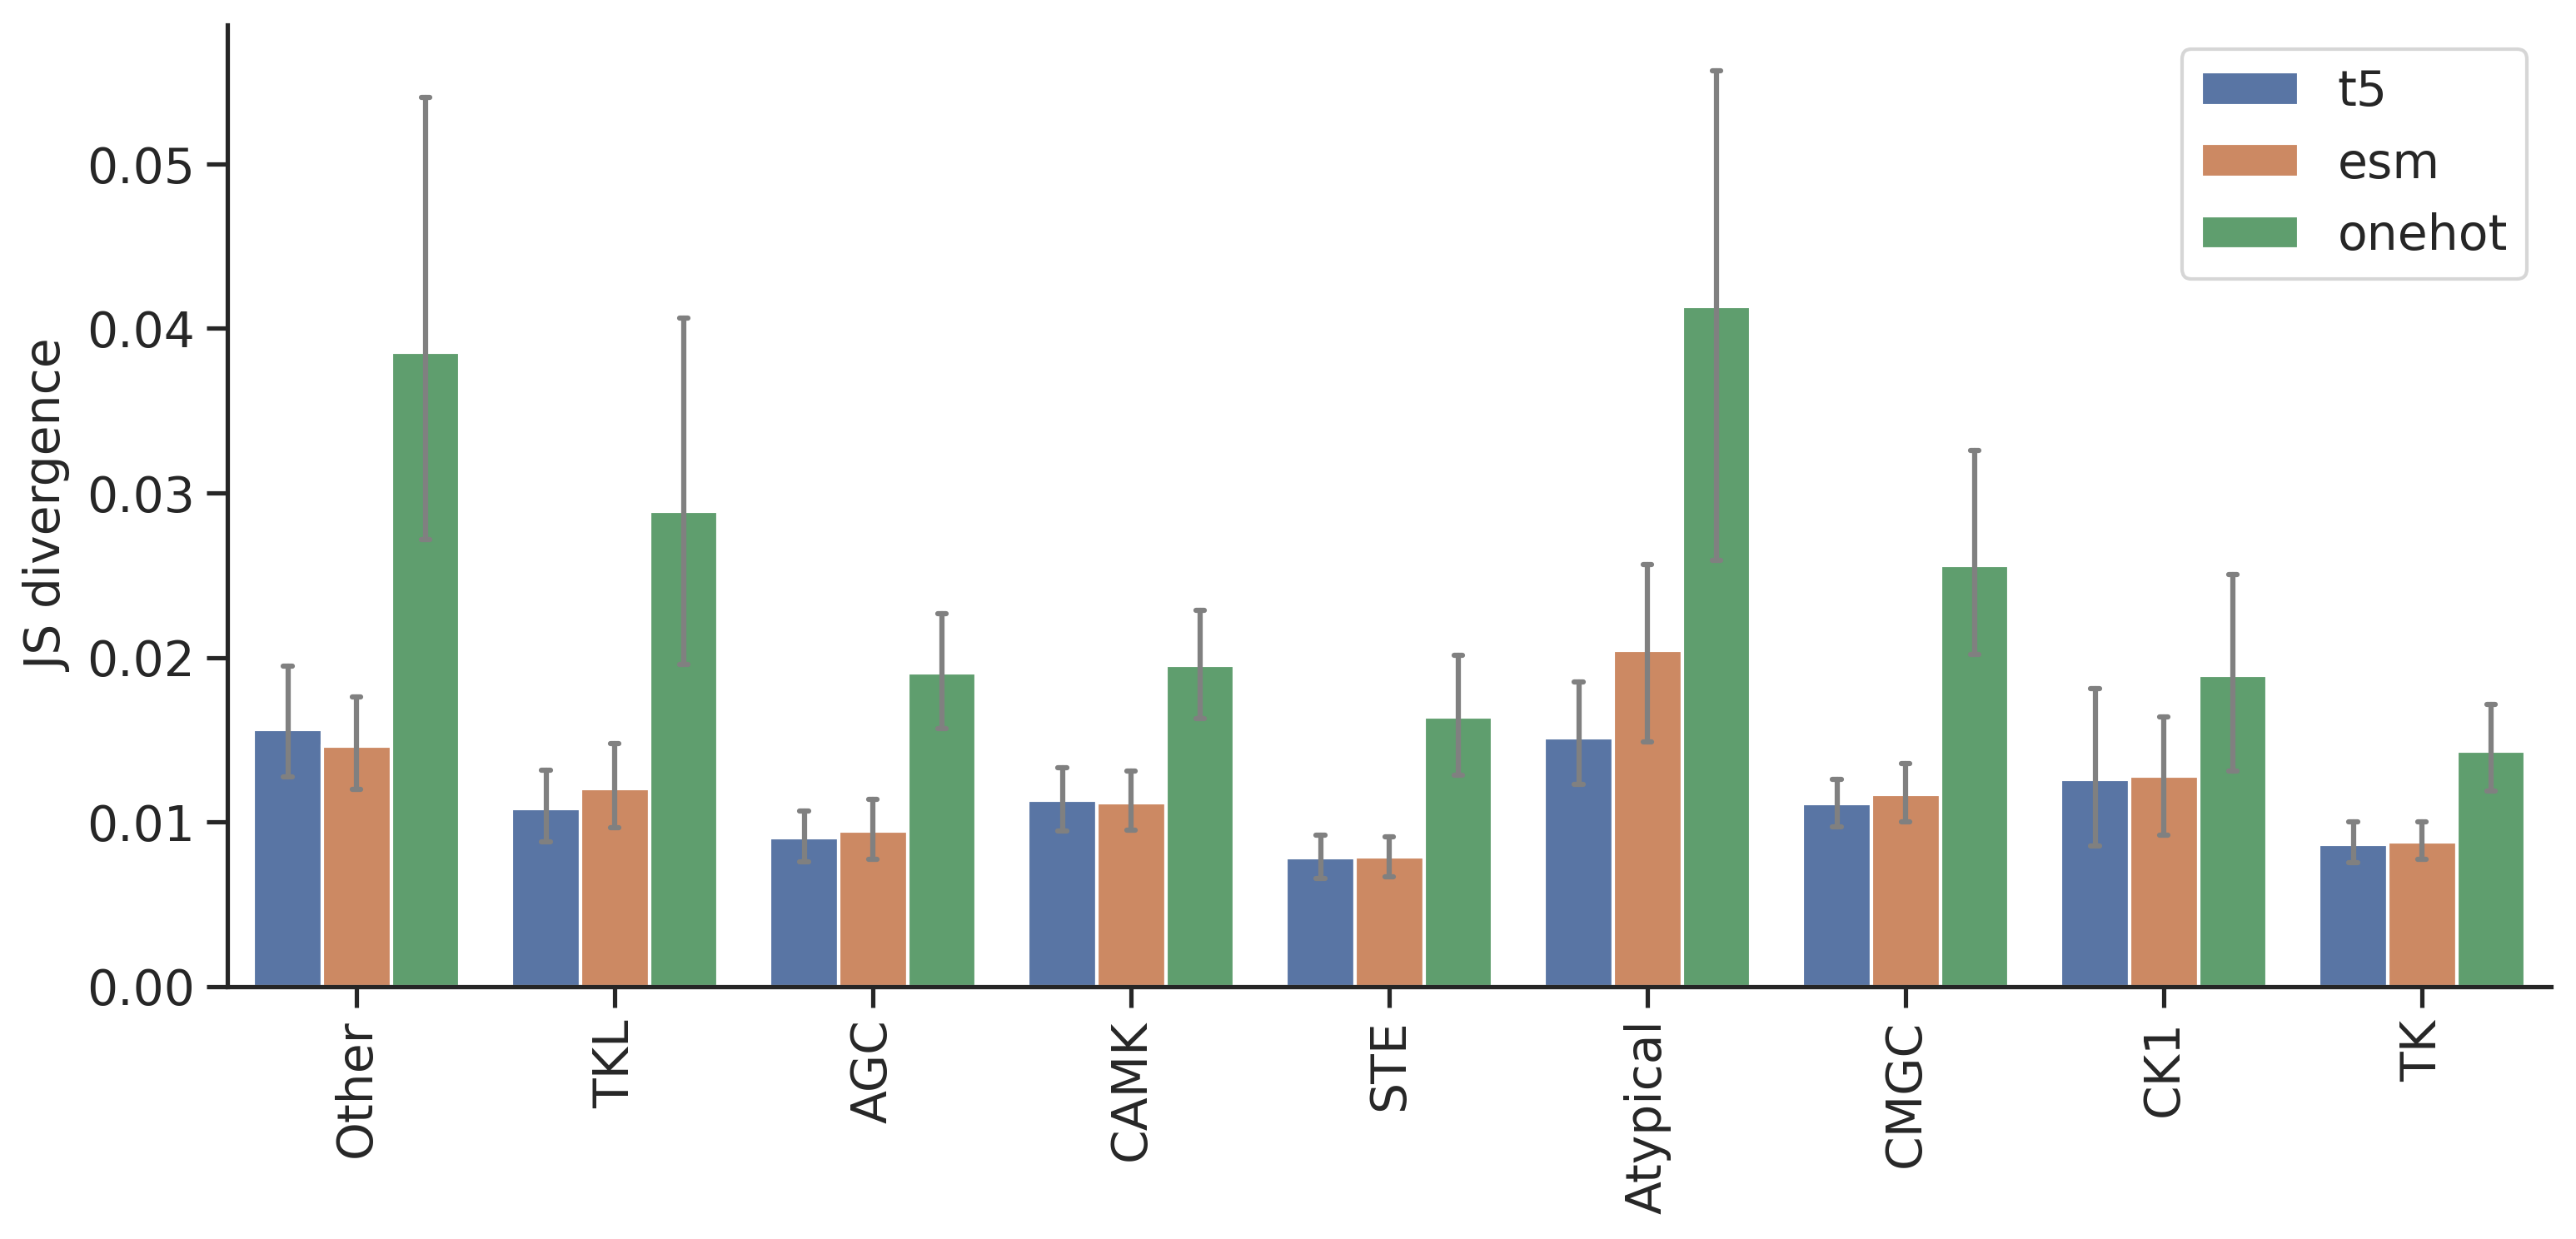

In [45]:
plot_group_bar(pspa_info,['t5','esm','onehot'],group='group')
plt.ylabel('JS divergence')